# Information Extraction with Regular Expression
In this notebook I first create a new dataframe containing all responses of all models of interest. The questionnaire these responses are based on is the selected questionnaire ("20240924_selected_questionnaire"). Second, a heuristic using regular expressions to precisely extract the chosen answer option is established. This is one of two approaches of extracting the answer labels and answers from the models responses.

## Dataset
Build the dataset out of the separate model interviews which will be further processed and analyzed.

In [1]:
# load packages
import os
import pandas as pd
import re
import numpy as np
import seaborn as sns
import scipy as sci
import matplotlib.pyplot as plt


In [2]:
# define the path to the responses from the test interviews
interview_path = "../assets/final_interviews/"

# model names
model_names = ["gemini_1.5", "Llama-3.1", "Llama-3.3", "mistral_7B", "Llama-3.2",
               "Qwen2.5", "Phi-3.5", "Yi-1.5"]

In [3]:
# define a function for retrieving the responses of interest

def find_matching_files(directory, string_list):
    matching_files = []
    
    # Iterate through all files in the specified directory
    for filename in os.listdir(directory):
        # Check if any part of the filename is in the list of strings
        if any(substring in filename for substring in string_list):
            matching_files.append(filename)
    
    return matching_files

In [4]:
final_interviews_paths = find_matching_files(interview_path, model_names)

In [5]:
# create an empty list to add all interviews and convert to a dataframe afterwards
interviews_list = []
num_interviews = []

for i in final_interviews_paths:
    df_interview = pd.read_csv(interview_path+i, sep = ";")
    num_interviews.append(len(df_interview))
    interviews_list.append(df_interview)
    print("Successfully appended: ", i)
    
# Concatenate them by rows
final_interviews = pd.concat(interviews_list, ignore_index=True)

Successfully appended:  20241211_gemini_1.5_selected_interviews.csv
Successfully appended:  20241211_Llama-3.1-8B_selected_interviews.csv
Successfully appended:  20241211_Llama-3.2-1B-Instruct_selected_interviews.csv
Successfully appended:  20241211_Llama-3.2-3B-Instruct_selected_interviews.csv
Successfully appended:  20241211_Llama-3.3-70B-Instruct_selected_interviews.csv
Successfully appended:  20241211_Phi-3.5-mini_selected_interviews.csv
Successfully appended:  20241211_Qwen2.5-7B-Instruct_selected_interviews.csv
Successfully appended:  20241211_Yi-1.5-6B-Chat_selected_interviews.csv
Successfully appended:  20241212_mistral_7B_selected_interviews.csv


In [6]:
# check length/number of interviews conducted
print("Number of interviews per model:\n", final_interviews["model_name"].value_counts())

# get sum of all interviews conducted
print("------------------------------ \nSum of all interviews:", sum(num_interviews))

Number of interviews per model:
 model_name
gemini-1.5-pro                20150
Meta-Llama-3.1-8B-Instruct    20150
Llama-3.2-1B-Instruct         20150
Llama-3.2-3B-Instruct         20150
Llama-3.3-70B-Instruct        20150
Phi-3.5-mini                  20150
Qwen2.5-7B-Instruct           20150
Yi-1.5-6B-Chat                20150
Mistral-7B-Instruct-v0.3      20150
Name: count, dtype: int64
------------------------------ 
Sum of all interviews: 181350


In [7]:
# save dataframe to csv
final_interviews.to_csv("../assets/final_interviews/ALL_unprocessed_selected_interviews.csv", sep=";")

## Processing
This subsection aims at processing the response answers into a standardized and uniform format. This is needed for further analysis.

### Regular Expression Processing
This subsection in processing displays the technique of answer extraction with regular expression.
In this process the complete response string is taken and subsequently sliced into positive/negative integers which resemble the label ID as well as the remaining full text which mostly resembles the label phrasing.

In [8]:
# convert response column cells to type string
final_interviews["response"] = final_interviews["response"].astype(str)

In [9]:
# Function to process the series
def process_series(series):
    response_label = []
    response_string = []
    
    for entry in series:
        # Extract words first (preserving spaces)
        words_only = re.sub(r"-?\d+", "", entry).replace("=", "").strip()
        
        # Remove all blankspaces and '=' for integer extraction
        cleaned_entry = entry.replace(" ", "").replace("=", "")
        
        # Extract all integers (positive or negative)
        numbers = re.findall(r"-?\d+", cleaned_entry)
        
        if len(numbers) > 1: # exclude answers which have more than one integer in its answer
            response_label.append(np.nan)
        elif numbers:
            response_label.append(",".join(numbers))  # Store integers found
        else:
            response_label.append(np.nan)  # If no integer is found, append NaN
            
        # Store the words (with spaces preserved)
        response_string.append(words_only if words_only else np.nan)
    
    # Create new DataFrame columns
    series_df = pd.DataFrame({
        "Original": series,
        "Response Label": response_label,
        "Response String": response_string
    })
    
    return series_df

# Apply the function to the Series
processed_df = process_series(final_interviews["response"])

# Display the result
print(processed_df)

                             Original Response Label           Response String
0                    1=Very important              1            Very important
1                    1=Very important              1            Very important
2                    1=Very important              1            Very important
3                    1=Very important              1            Very important
4                  1 (Very important)              1          (Very important)
...                               ...            ...                       ...
161195  1=Not an essential feature \n              1  Not an essential feature
161196  1=Not an essential feature \n              1  Not an essential feature
161197  1=Not an essential feature \n              1  Not an essential feature
161198  1=Not an essential feature \n              1  Not an essential feature
161199  1=Not an essential feature \n              1  Not an essential feature

[161200 rows x 3 columns]


In [10]:
final_interviews_processed = pd.concat([final_interviews, processed_df[["Response Label","Response String"]]], axis=1)

# final_interviews_processed.rename(columns={"type": "Type"}, inplace=True)

# # Differentiate between bias and non-bias perturbations
# bias_answer_columns = ["list_answer_no_refusal","list_answer_no_middle","list_answer_options_reversed"]
# non_bias_question_columns = ["question_typo", "question_letter_swap","question_synonym","question_paraphrased"]
# all_perturbation_columns = bias_answer_columns + non_bias_question_columns


# # define filtering columns for better separation between perturbation domains
# final_interviews_processed["bias_perturbation"] = np.where((final_interviews_processed['Type'].isin(bias_answer_columns)) | (final_interviews_processed['Type'] == "list_answer_options"), 1, 0)
# final_interviews_processed["non_bias_perturbation"] = np.where((final_interviews_processed['Type'] == "list_answer_options") | (final_interviews_processed['Type'].isin(non_bias_question_columns)), 1, 0)


In [11]:
# save dataframe to csv
final_interviews_processed.to_csv("../assets/final_interviews/ALL_first_regex-processed_selected_interviews.csv", sep=";")

In [12]:
final_interviews_processed["model_name"].value_counts()

model_name
Mistral-7B-Instruct-v0.3      20150
Meta-Llama-3.1-8B-Instruct    20150
Gwen2.5-7B-Instruct           20150
Phi-3.5-mini                  20150
Yi-1.5-6B-Chat                20150
Llama-3.2-1B-Instruct         20150
Llama-3.2-3B-Instruct         20150
gemini-1.5-pro                20150
Name: count, dtype: int64

In [16]:
model_success_rate = final_interviews_processed.groupby("model_name")["Response Label"]
gemini_success_rate = 1 - len(final_interviews_processed[(final_interviews_processed["model_name"] == "gemini-1.5-pro") & (final_interviews_processed["Response Label"].isnull())])/len(final_interviews_processed[final_interviews_processed["model_name"] == "gemini-1.5-pro"])
llama3_success_rate = 1 - len(final_interviews_processed[(final_interviews_processed["model_name"] == "Meta-Llama-3.1-8B-Instruct") & (final_interviews_processed["Response Label"].isnull())])/len(final_interviews_processed[final_interviews_processed["model_name"] == "Meta-Llama-3.1-8B-Instruct"])
mistral7B_success_rate = 1 - len(final_interviews_processed[(final_interviews_processed["model_name"] == "Mistral-7B-Instruct-v0.3") & (final_interviews_processed["Response Label"].isnull())])/len(final_interviews_processed[final_interviews_processed["model_name"] == "Mistral-7B-Instruct-v0.3"])
phimini_success_rate = 1 - len(final_interviews_processed[(final_interviews_processed["model_name"] == "Phi-3.5-mini") & (final_interviews_processed["Response Label"].isnull())])/len(final_interviews_processed[final_interviews_processed["model_name"] == "Phi-3.5-mini"])
Yi6B_success_rate = 1 - len(final_interviews_processed[(final_interviews_processed["model_name"] == "Yi-1.5-6B-Chat") & (final_interviews_processed["Response Label"].isnull())])/len(final_interviews_processed[final_interviews_processed["model_name"] == "Yi-1.5-6B-Chat"])
gwen7B_success_rate = 1 - len(final_interviews_processed[(final_interviews_processed["model_name"] == "Gwen2.5-7B-Instruct") & (final_interviews_processed["Response Label"].isnull())])/len(final_interviews_processed[final_interviews_processed["model_name"] == "Gwen2.5-7B-Instruct"])
llama1B_success_rate = 1 - len(final_interviews_processed[(final_interviews_processed["model_name"] == "Llama-3.2-1B-Instruct") & (final_interviews_processed["Response Label"].isnull())])/len(final_interviews_processed[final_interviews_processed["model_name"] == "Llama-3.2-1B-Instruct"])
llama3B_success_rate = 1 - len(final_interviews_processed[(final_interviews_processed["model_name"] == "Llama-3.2-3B-Instruct") & (final_interviews_processed["Response Label"].isnull())])/len(final_interviews_processed[final_interviews_processed["model_name"] == "Llama-3.2-3B-Instruct"])


#mixtral8x7B_success_rate = 1 - len(test_interviews_processed[(test_interviews_processed["model_name"] == "Mixtral-8x7B-Instruct-v0.1") & (test_interviews_processed["Response Label"].isnull())])/len(test_interviews_processed[test_interviews_processed["model_name"] == "Mixtral-8x7B-Instruct-v0.1"])

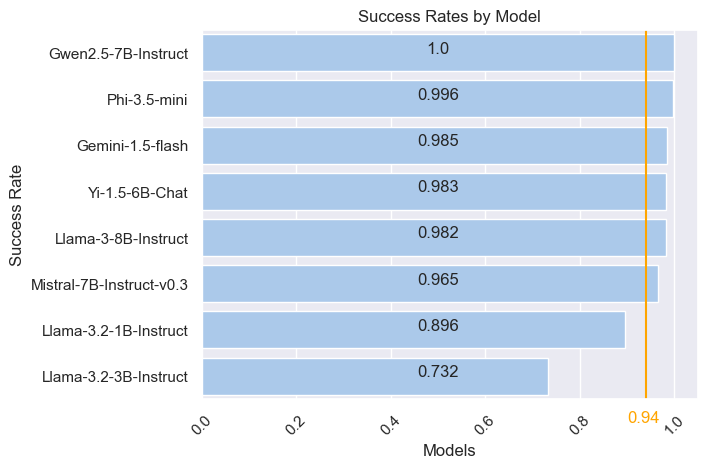

In [17]:
# Replace these with your four numbers
numbers = [mistral7B_success_rate, gemini_success_rate, llama3_success_rate,
           llama1B_success_rate, llama3B_success_rate, 
           phimini_success_rate, Yi6B_success_rate, gwen7B_success_rate]
models = ["Mistral-7B-Instruct-v0.3","Gemini-1.5-flash", "Llama-3-8B-Instruct", 
          "Llama-3.2-1B-Instruct", "Llama-3.2-3B-Instruct",
          "Phi-3.5-mini", "Yi-1.5-6B-Chat", "Qwen2.5-7B-Instruct"]

success_rates = pd.DataFrame({
    "success_rate" : numbers,
    "model": models
}).sort_values(by="success_rate", ascending=False)

# Calculate the mean
mean_value = round((1-sum(final_interviews_processed["Response Label"].isnull())/len(final_interviews_processed)), 2)


# Create a bar plot using Seaborn
sns.set_theme(style="darkgrid", palette="pastel")
sns.barplot(y=success_rates["model"], x=success_rates["success_rate"])

# Add labels with rounded numbers
for i,k in enumerate(success_rates["success_rate"]):
    plt.text(0.5, i, f"{round(k, 3)}", ha="center")

plt.text(mean_value-0.04, 8, f"{round(mean_value, 3)}", color="orange")
# Add a horizontal line at the mean
plt.axvline(x=mean_value, color='orange', linestyle='-', label=f'Mean: {mean_value:.2f}')

# Rotate x labels
plt.xticks(rotation=45)
# Customize the plot (optional)
plt.xlabel("Models")
plt.ylabel("Success Rate")
plt.title("Success Rates by Model")

# Show the plot
plt.show()

### 2. Approach: Conditional Extraction
This extraction methods respects multiple conditions when extracting the correct label from the model response. First, all possible answer options are taken into account for each response and compared. Thus, if a response does not contain any answer option available, it will be classified as "None". Second, it is checked how many answer options are available or given in one response. If there are more than one answer options, this response is also classified as "None" and thus unsuccessful. Third, if only one answer option is present in the response and it is matching one of the prior available answer options, the model should choose from, the corresponding integer is extracted. 

In [8]:
import pandas as pd
import re

# Sample DataFrame
data = {
    'answer_options': ["-1=Don't know, 1=Agree, 2=Disagree, 5, 6"]*5,
    'response': ["-1=Don't know", # expected output: -1
                 '15 and -5 are possible', # expected output: None, because two answers
                 '-1No response here, but also 1=Agree', # expected output: None, because two answers
                 'Agree', # expected output: 1
                 "5"] # expected output: 5
}
df = pd.DataFrame(data)

def process_row(row):
    row["response"] = str(row["response"])
    # Step 1: Create the dictionary by extracting integers and associated text from "answer_options"
    answer_dict = {}
    for match in re.finditer(r'(-?\d+)(?:=([^,]+))?', row['answer_options']):
        integer = int(match.group(1))   # Key: integer before the '='
        text = match.group(2).strip() if match.group(2) else None  # Value: text after the '=', or None if not present
        answer_dict[integer] = text


    # Step 2: Extract all integers from "answer_options" for comparison 
    answer_integers = list(answer_dict.keys())

    # Step 3: Extract integers from "response"
    response_integers = list(map(int, re.findall(r'-?\d+', row['response'])))
    
    # Step 4: Apply conditions
    extracted_response = None
    if len(response_integers) == 1 and response_integers[0] in answer_integers:
        # Condition 6: Single matching integer in response
        extracted_response = response_integers[0]
    elif len(response_integers) != 1:
        # Condition 3 and 4: No integer or multiple integers in response
        # Check for text-based match if there are no integers in "response"
        if len(response_integers) == 0:
            for key, value in answer_dict.items():
                if value is not None and value in row['response']:  # Skip None values
                    extracted_response = key
                    break
    return pd.Series([extracted_response, answer_dict])

# Apply the function to each row in the DataFrame and expand results into new columns
df[['extracted_response', 'answer_dict']] = df.apply(process_row, axis=1)

print(df)

                             answer_options  \
0  -1=Don't know, 1=Agree, 2=Disagree, 5, 6   
1  -1=Don't know, 1=Agree, 2=Disagree, 5, 6   
2  -1=Don't know, 1=Agree, 2=Disagree, 5, 6   
3  -1=Don't know, 1=Agree, 2=Disagree, 5, 6   
4  -1=Don't know, 1=Agree, 2=Disagree, 5, 6   

                               response  extracted_response  \
0                         -1=Don't know                -1.0   
1                15 and -5 are possible                 NaN   
2  -1No response here, but also 1=Agree                 NaN   
3                                 Agree                 1.0   
4                                     5                 5.0   

                                         answer_dict  
0  {-1: 'Don't know', 1: 'Agree', 2: 'Disagree', ...  
1  {-1: 'Don't know', 1: 'Agree', 2: 'Disagree', ...  
2  {-1: 'Don't know', 1: 'Agree', 2: 'Disagree', ...  
3  {-1: 'Don't know', 1: 'Agree', 2: 'Disagree', ...  
4  {-1: 'Don't know', 1: 'Agree', 2: 'Disagree', ...  


In [9]:
# test code on subset of interviews
#final_interviews[['extracted_response', 'answer_dict']]  = final_interviews.iloc[161150:161200].apply(process_row, axis=1)

# This code snippet is applying the function `process_row` to each row in the `final_interviews` DataFrame at index position 161199. It then assigns the returned values from the function to the columns 'extracted_response' and 'answer_dict' in the same row.
final_interviews[['extracted_response', 'answer_dict']] = final_interviews.apply(process_row, axis=1)

In [10]:
# save dataframe to csv
final_interviews.to_csv("../assets/final_interviews/ALL_regex_complete-processed_selected_interviews.csv", sep=";")